In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Routing

Often when creating a design, you need to connect geometries together with wires or waveguides.  To help with that, PHIDL has the `phidl.routing` (`pr`) module, which can flexibly and quickly create routes between ports.

## Simple quadrilateral routes

In general, a route is a polygon used to connect two ports. Simple routes are easy to create using `pr.route_quad()`. This function returns a quadrilateral route that directly connects two ports,  as shown in this example:

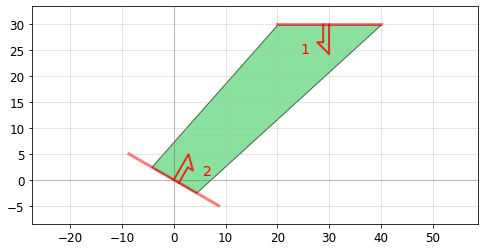

In [2]:
from phidl import Device
from phidl import quickplot as qp
from phidl import set_quickplot_options
import phidl.routing as pr

set_quickplot_options(show_ports=True, show_subports=False)

D = Device()
port1 = D.add_port(name=1, midpoint=(30, 30), width=20, orientation=270)
port2 = D.add_port(name=2, midpoint=(0, 0), width=20, orientation=60)

D.add_ref(pr.route_quad(port1, port2, width2 = 10))
qp(D)

## Automatic manhattan routing

Often, such simple quadrilateral routes aren't good enough. For example, maybe:
+ the ports face away from each other, or
+ we need to route around another device in our layout, or
+ we want to route waveguides with well-defined smooth bends, or
+ we want to use a manhattan routing style (i.e. vertical and horizontal lines).

In these cases, we can instead use the routing functions `pr.route_smooth()` and `pr.route_sharp()`. These functions allow you to route along a `Path`, and come with built-in options that let you control the shape of the path and how to extrude it. 

If you don't need detailed control over the path your route takes, you can let these functions create an automatic manhattan route by setting `path_type='manhattan'`. Just make sure the ports you're to routing between face parrallel or orthogonal directions. 

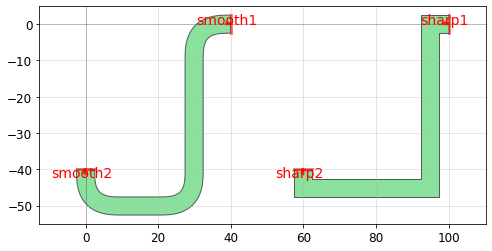

In [3]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=5, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan'))

port3 = D.add_port(name='sharp1', midpoint=(100,0), width=5, orientation=180)
port4 = D.add_port(name='sharp2', midpoint=(60, -40), width=5, orientation=270)
D.add_ref(pr.route_sharp(port3, port4, path_type='manhattan'))

qp(D)

The `route_smooth()` function works in three steps:
1. It calculates a waypoint `Path` using a waypoint path function -- such as `pr.path_manhattan()` -- set by the `path_type`.
2. It smooths out the waypoint `Path` using `pp.smooth()`.
3. It extrudes the `Path` to create the route geometry.

The `route_sharp()` function works similarly, but it omits step 2 to create sharp bends. The extra smoothing makes `route_smooth()` particularly useful for waveguides, whereas `route_sharp()` is typically more useful for electrical wiring. 

To illustrate how these functions work, let's look at how you could manually implement a similar behaviour to `route_smooth(path_type='manhattan')`:

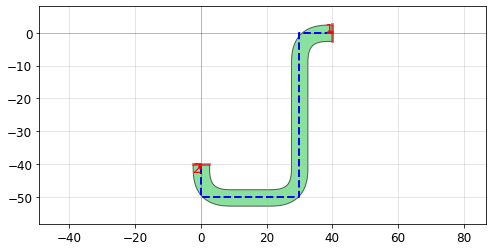

In [4]:
from phidl import CrossSection
import phidl.path as pp

D = Device()
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)
# step 1: calculate waypoint path
route_path = pr.path_manhattan(port1, port2, radius=10)
# step 2: smooth waypoint path
smoothed_path = pp.smooth(route_path, radius=10, use_eff=True)
# step 3: extrude path
D.add_ref(smoothed_path.extrude(width=5, layer=0))
qp([route_path,D])

These routing functions `pr.route_smooth()` and `pr.route_sharp()` have arguments that allow you to customize every step of the route-creation process:

__Example 1: Routing with arbitrary `CrossSection`.__ By default with `width=None`, these routing functions will extrude the waypoint path with a width that tapers linearly between the port widths. However, we can also pass any `width` argument we like onward to `Path.extrude()`. For example, we can extrude a custom `CrossSection` with multiple layers:

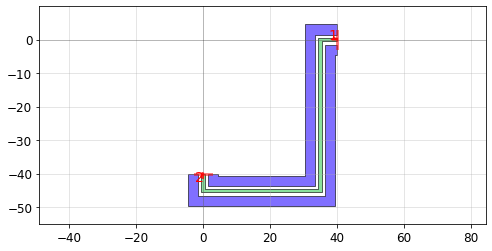

In [5]:
D = Device()
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)
X = CrossSection().add(width=1, layer=0)
X.add(width=3,offset=3, layer=1)
X.add(width=3, offset=-3, layer=1)
D.add_ref(pr.route_sharp(port1, port2, path_type='manhattan', width=X))

qp(D)

__Example 2: Adjusting `pp.smooth()` options to make circular bends.__ We can customize the bends produced by `pr.route_smooth()` using the `smooth_options`, which are passed to `pp.smooth()`.

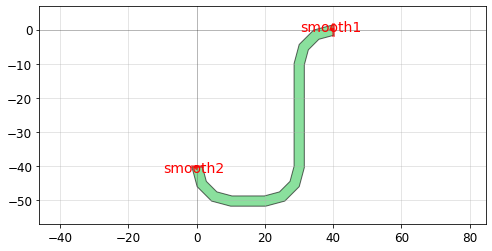

In [6]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=3, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=3, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=10, smooth_options={'corner_fun': pp.arc, 'num_pts': 16}))
qp(D)

## Customizing route paths

Sometimes, automatic routes will run into another device in your layout, like this:

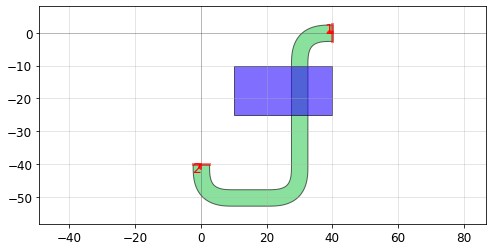

In [7]:
import phidl.geometry as pg

D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15), layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan'))
qp(D)

__Example 1: Custom `J` paths.__ To avoid the other device, we need to customize the path our route takse. Luckily, PHIDL provides several waypoint path functions to help us do that quickly. Each of these waypoint path functions has a name of the form `pr.path_***` (e.g. `pr.path_L()`), and generates a particular path type with its own shape. All the available path types are described in detail below and in the __Geometry Reference__. In this case, we want to connect two orthogonal ports, but the ports are positioned such that we can't connect them with a single 90-degree turn. A `J`-shaped path with four line segments and three turns is perfect for this problem. We can tell `route_smooth` to use `pr.path_J()` as its waypoint path function via the argument `path_type='J'`.

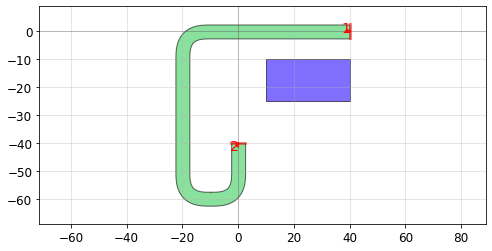

In [8]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15), layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='J', length1=60, length2=20))
qp(D)


For ease of use, the waypoint path functions are parameterized in terms of relative distances from ports. Above, we had to define the keyword arguments `length1` and `length2`, which are passed to `pr.route_J()` for the waypoint path calculation. These arguments `length1` and `length2` define the lengths of the line segments that exit `port1` and `port2` respectively (i.e. the first and last sements in the path). Once those first and last segments are set, `path_J()` completes the waypoint path with two more 90-degree turns. Note that just knowing `length1` and `length2`, along with the port positions and orientations, is enough to completely determine the waypoint path.

__Example 2: Custom `C` paths.__ Now consider this routing problem:

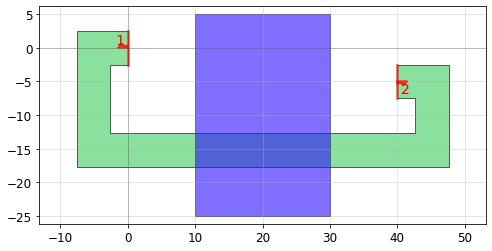

In [9]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(20,30),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(0,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(40, -5), width=5, orientation=0)

D.add_ref(pr.route_sharp(port1, port2, path_type='manhattan'))
qp(D)

In this case, we want a `C` path. `C` paths have three parameters we need to define: 
+ `length1` and `length2`, which are the lengths of the segments that exit `port1` and `port2` (similar to the `J` path), as well as 
+ `left1`, which is the length of the segment that turns *left* from `port1`. 

In this case, we would actually prefer that the path turns *right* after it comes out of `port1`, so that our route avoids the other device. To make that happen, we can just set `left1<0`:

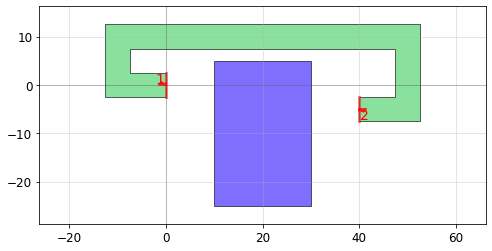

In [10]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(20,30),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(0,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(40, -5), width=5, orientation=0)

D.add_ref(pr.route_sharp(port1, port2, path_type='C', length1=10, length2=10, left1=-10))
qp(D)

__Example 3: Custom `manual` paths.__ For even more complex route problems, we can use `path_type='manual'` to create a route along an arbitrary path. In the example below, we use a manual path to route our way out of a sticky situation:

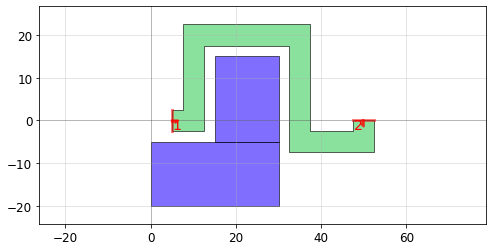

In [11]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((0, -20))
other_device2 = D.add_ref(pg.rectangle(size=(15,20), layer=1))
other_device2.xmax = other_device.xmax
other_device2.ymin = other_device.ymax
port1 = D.add_port(name=1, midpoint=(5,0), width=5, orientation=0)
port2 = D.add_port(name=2, midpoint=(50, 0), width=5, orientation=270)

manual_path = [ port1.midpoint,
                (other_device2.xmin-5, port1.y),
                (other_device2.xmin-5, other_device2.ymax+5),
                (other_device2.xmax+5, other_device2.ymax+5),
                (other_device2.xmax+5, port2.y-5),
                (port2.x, port2.y-5),
                port2.midpoint ]

D.add_ref(pr.route_sharp(port1, port2, path_type='manual', manual_path=manual_path))
qp(D)

Note that to manually route between two ports, the first and last points in the `manual_path` should be the midpoints of the ports. 

## Waypoint path types

PHIDL provides the following waypoint path types for routing:

| Path type   | Routing style| Segments   | Useful for ... | Parameters |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| `straight`  | Manhattan   | 1           | ports that point directly at each other.| -- |
| `L`         | Manhattan   | 2           | orthogonal ports that can be connected with one turn.| -- |
| `U`         | Manhattan   | 3           | parrallel ports that face each other or same direction.| `length1` |
| `J`         | Manhattan   | 4           | orthogonal ports that can't be connected with just one turn.| `length1`, `length2` |
| `C`         | Manhattan   | 5           | parrallel ports that face apart.| `length1`, `length2`, `left1` |
| `manhattan` | Manhattan   | 1-5         | parrallel or orthogonal ports.| `radius` |
| `V`         | Free        | 2           | ports at odd angles that face a common intersection point.| -- |
| `Z`         | Free        | 3           | ports at odd angles.| `length1`, `length2` |
| `manual`    | Free        | --          | fully custom paths. | `manual_path` |

For more details on each path type, you can also look at the __API Documentation__ or the __Geometry Reference__.

The path types can be classified by their routing style. Manhattan style routing uses only 90-degree turns, and thus requires that you route between ports that are orthogonal or parrallel (note that the ports don't neccearrily have to point horizontally or vertically, though). For routing between ports at odd angles, you can use path types with a free routing style instead.

Most path types are named after letters that they resemble to help you remember them. However, as you'll see in the examples below, some of the more complicated paths can take a variety of shapes. One good way to identify which manhattan-style route type you need is to count the number of line segments and consult the above table.

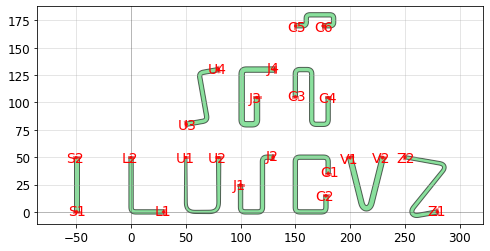

In [12]:
D = Device()

#straight path
port1 = D.add_port(name='S1', midpoint=(-50, 0), width=4, orientation=90)
port2 = D.add_port(name='S2', midpoint=(-50, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='straight'))
#L path
port1 = D.add_port(name='L1', midpoint=(30,0), width=4, orientation=180)
port2 = D.add_port(name='L2', midpoint=(0, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  path_type='L'))
#U path
port1 = D.add_port(name='U1', midpoint=(50, 50), width=2, orientation=270)
port2 = D.add_port(name='U2', midpoint=(80,50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  radius=10, path_type='U', length1=50))
port1 = D.add_port(name='U3', midpoint=(50, 80), width=4, orientation=10)
port2 = D.add_port(name='U4', midpoint=(80, 130), width=4, orientation=190)
D.add_ref(pr.route_smooth(port1, port2,  path_type='U', length1=20))
#J path
port1 = D.add_port(name='J1', midpoint=(100, 25), width=4, orientation=270)
port2 = D.add_port(name='J2', midpoint=(130, 50), width=4,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2,  path_type='J', length1=25, length2=10))
port1 = D.add_port(name='J3', midpoint=(115, 105), width=5, orientation=270)
port2 = D.add_port(name='J4', midpoint=(131, 130), width=5,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2, path_type='J', length1=25, length2=30))
#C path
port1 = D.add_port(name='C1', midpoint=(180, 35), width=4, orientation=90)
port2 = D.add_port(name='C2', midpoint=(178, 15), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=15, left1=30, length2=15))
port1 = D.add_port(name='C3', midpoint=(150, 105), width=4, orientation=90)
port2 = D.add_port(name='C4', midpoint=(180, 105), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=25, left1=-15, length2=25))
port1 = D.add_port(name='C5', midpoint=(150, 170), width=4, orientation=0)
port2 = D.add_port(name='C6', midpoint=(175, 170), width=4, orientation=0)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=10, left1=10, length2=10, radius=4))
#V path
port1 = D.add_port(name='V1', midpoint=(200,50), width=5, orientation=284)
port2 = D.add_port(name='V2', midpoint=(230, 50), width=5, orientation=270-14)
D.add_ref(pr.route_smooth(port1, port2, path_type='V'))
#Z path
port1 = D.add_port(name='Z1', midpoint=(280,0), width=4, orientation=190)
port2 = D.add_port(name='Z2', midpoint=(250, 50), width=3, orientation=-10)
D.add_ref(pr.route_smooth(port1, port2, path_type='Z', length1=30, length2=40))


qp(D)

The `manhattan` path type is bending-radius aware and can produce any route neccessary to connect two ports, as long as they are orthogonal or parrallel. 

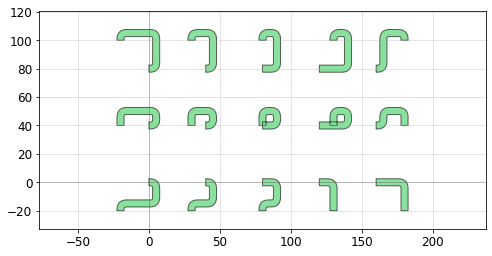

In [13]:
import numpy as np

set_quickplot_options(show_ports=False, show_subports=False)

D = Device() 
pitch = 40
test_range=20
x_centers = np.arange(5)*pitch
y_centers = np.arange(3)*pitch
xoffset = np.linspace(-1*test_range, test_range, 5)
yoffset = np.linspace(-1*test_range, test_range, 3)
for xidx, x0 in enumerate(x_centers):
    for yidx, y0 in enumerate(y_centers):
        name = '{}{}'.format(xidx, yidx)
        port1 = D.add_port(name=name+'1', midpoint=(x0, y0), width=5, orientation=0)
        port2 = D.add_port(name=name+'2', midpoint=(x0+xoffset[xidx], y0+yoffset[yidx]), 
                           width=5,  orientation=90)
        D.add_ref(pr.route_smooth(port1, port2, route_type='manhattan'))
qp(D)